# Monte Carlo Simulation with Historical and GARCH-Based Volatility

This project aims to simulate the future price of a financial asset using two different approaches for modeling volatility:

1. **Historical volatility** (assumed constant): implemented using a Geometric Brownian Motion (GBM).
2. **GARCH-based conditional volatility** (time-varying): implemented using a GJR-GARCH(1,1) model.

We perform Monte Carlo simulations for both approaches and compare their forecasted price paths, risk levels, and volatility structures.

The asset used for this study is **Apple Inc. (AAPL)**.


## Downloading and Visualizing Historical Stock Data

This section focuses on downloading and visualizing historical stock data using the `yfinance` library.

**Execution:**
   - The historical data for Apple (AAPL) is downloaded from 2005-01-01 to 2023-12-31.
   - The closing prices are plotted to show the stock's historical performance.

[*********************100%***********************]  1 of 1 completed


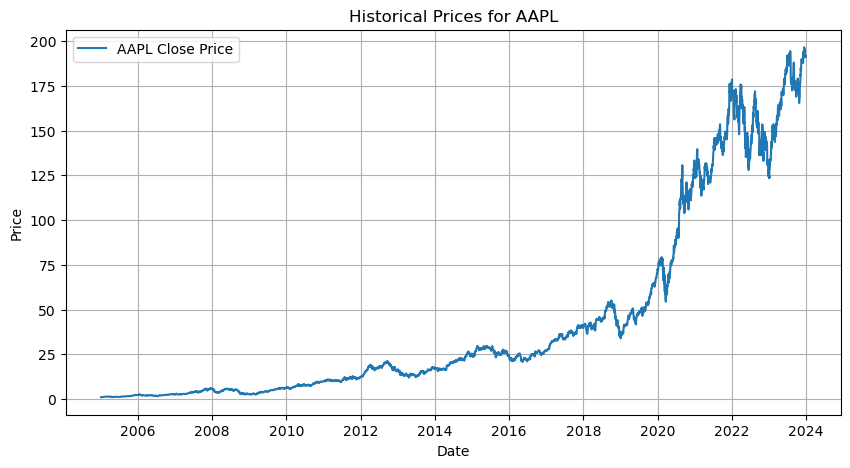

In [15]:
# Import necessary libraries
import yfinance as yf  # yfinance for downloading stock market data
import pandas as pd  # pandas for data manipulation and analysis
import numpy as np  # numpy for numerical operations
import matplotlib.pyplot as plt  # matplotlib for creating visualizations
from scipy.stats import norm

# Define a function to download historical stock data
def download_stock_data(ticker, start_date, end_date):
    # Download the stock data from Yahoo Finance
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Define a function to plot the closing prices of a stock
def plot_stock_data(data, ticker):
    plt.figure(figsize=(10, 5)) # Set the figure size for the plot
    plt.plot(data['Close'], label=f'{ticker} Close Price') # Set the figure size for the plot
    plt.title(f'Historical Prices for {ticker}') # Add title and labels to the plot
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Download historical stock data for Apple (AAPL) for the year 2023
data = download_stock_data('AAPL', '2005-01-01', '2023-12-31')

# Plot the historical closing prices for Apple (AAPL)
plot_stock_data(data, 'AAPL')


# Logarithmic Returns
Logarithmic returns provide a more symmetric measure of percentage changes in stock prices. They are computed using the formula:

$$
\text{Log Return}_t = \ln\left(\frac{\text{Price}_t}{\text{Price}_{t-1}}\right)
$$

## Steps:
1. **Calculate Log Returns**: The function `calculate_log_returns` computes the log returns based on the closing prices of the stock.
2. **Plot Log Returns**: The function `plot_log_returns` visualizes the calculated returns over time.

## Interpretation:
The log returns provide insight into the stock's daily price changes, with positive values indicating price increases and negative values indicating decreases.


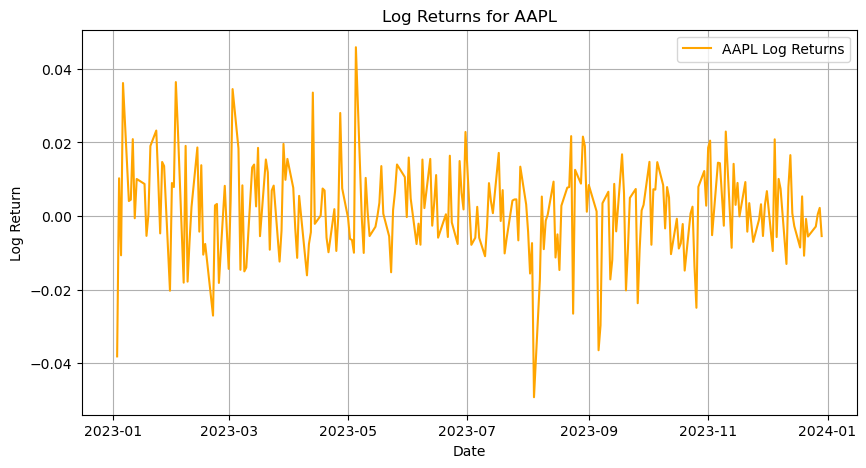

In [16]:
# Define a function to calculate logarithmic returns of a stock
def calculate_log_returns(data):
    data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1)) # Calculate log returns using the formula: log(C_t / C_(t-1))
    return data

# Define a function to plot the logarithmic returns of a stock
def plot_log_returns(data, ticker, start_date= '2023-01-01'):
    filtered_data = data[data.index >= start_date] # Filter historical data to start from the specified date
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_data['Log Returns'], label=f'{ticker} Log Returns', color='orange') # Plot the logarithmic returns of the stock
    plt.title(f'Log Returns for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the log returns for Apple (AAPL) and add them to the DataFrame
data = calculate_log_returns(data)

# Plot the log returns for Apple (AAPL)
plot_log_returns(data, 'AAPL')


## Method 1: Monte Carlo Simulation with Historical Volatility

In this section, we use a simple Geometric Brownian Motion (GBM) model, where volatility is estimated from historical daily log-returns. The simulation assumes:

- Constant drift and volatility
- Normally distributed shocks (white noise)
- Log-normal price evolution

This approach is classical but may underestimate risk by ignoring volatility clustering and asymmetry.


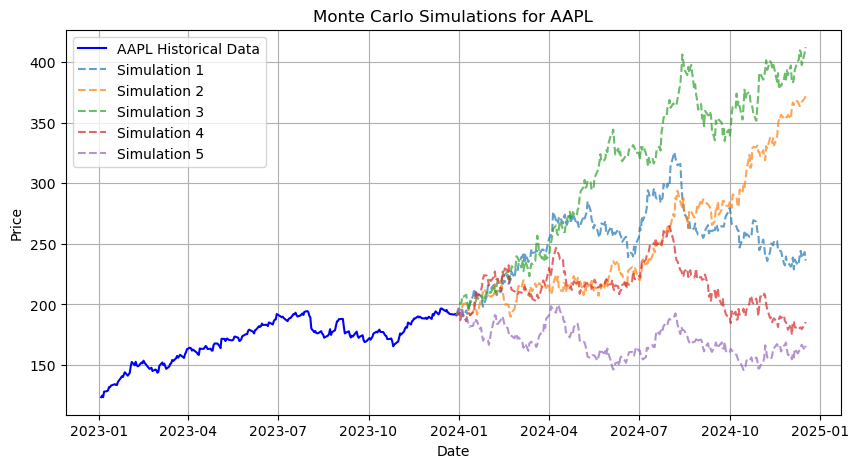

95% Confidence Interval for Final Prices: (259.8417890606009, 271.1011814113071)


In [17]:
# Define a function to simulate Monte Carlo trajectories for stock prices
def monte_carlo_simulation(data, num_simulations, num_days, mu=None, sigma=None):
    # If mu and sigma are not provided, calculate them from historical log returns
    if mu is None or sigma is None:
        mu = data['Log Returns'].mean()
        sigma = data['Log Returns'].std()
    # Initial stock price (last closing price in the historical data)
    S0 = data['Close'].iloc[-1]
    dt = 1  # Time step in days
    simulations = []  # List to store all simulated trajectories
    # Generate Monte Carlo trajectories
    for _ in range(num_simulations):
        prices = [S0]  # Initialize trajectory with the current stock price
        for _ in range(num_days):
            # Calculate drift and shock components
            drift = mu * dt
            shock = sigma * np.random.normal(0, 1) * np.sqrt(dt)
            # Update the price using the geometric Brownian motion formula
            price = prices[-1] * np.exp(drift + shock)
            prices.append(price)
        simulations.append(prices)  # Append the trajectory to the list
    return simulations


# Define a function to plot Monte Carlo simulations alongside historical data
def plot_monte_carlo(data, simulations, ticker, start_date='2023-01-01'):
    # Filter historical data to start from the specified date
    filtered_data = data[data.index >= start_date]
    # Set the figure size for the plot
    plt.figure(figsize=(10, 5))
    # Plot historical closing prices
    plt.plot(filtered_data['Close'], label=f'{ticker} Historical Data', color='blue')
    # Generate a time index for the simulated trajectories
    time_index = pd.date_range(start=data.index[-1], periods=len(simulations[0]), freq='B')
    # Plot each Monte Carlo simulation trajectory
    for i, simulation in enumerate(simulations):
        plt.plot(time_index, simulation, linestyle='--', alpha=0.7, label=f'Simulation {i + 1}')
    # Add title, labels, legend, and grid for better readability
    plt.title(f'Monte Carlo Simulations for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def calculate_final_price_confidence_interval(data, num_simulations, num_days, confidence, mu, sigma):
    # Use historical mu and sigma if not provided
    if mu is None or sigma is None:
        mu = data['Log Returns'].mean()
        sigma = data['Log Returns'].std()
    # Initial stock price (last closing price in the historical data)
    S0 = data['Close'].iloc[-1]
    dt = 1  # Time step in days
    final_prices = []  # List to store final values of simulations
    # Generate Monte Carlo trajectories
    for _ in range(num_simulations):
        prices = [S0]  # Initialize trajectory with the current stock price
        for _ in range(num_days):
            # Calculate drift and shock components
            drift = mu * dt
            shock = sigma * np.random.normal(0, 1) * np.sqrt(dt)
            # Update the price using the geometric Brownian motion formula
            price = prices[-1] * np.exp(drift + shock)
            prices.append(price)
        final_prices.append(prices[-1])  # Store the final price of this trajectory
    # Convert final prices to a numpy array
    final_prices = np.array(final_prices)
    # Calculate mean and standard error of the final prices
    mean = np.mean(final_prices)
    std_err = np.std(final_prices, ddof=1) / np.sqrt(len(final_prices))  # Error standard of final prices
    # Calculate z-critical value for the confidence level
    z_crit = norm.ppf((1 + confidence) / 2)
    # Calculate margin of error
    margin_of_error = z_crit * std_err
    # Calculate confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    return ci_lower, ci_upper

# Run Monte Carlo simulations for Apple (AAPL) for 252 days (1 trading year) with 5 trajectories
simulations = monte_carlo_simulation(data, num_simulations=5, num_days=252)

# Plot the Monte Carlo simulations alongside the historical data starting from 2023-01-01
plot_monte_carlo(data, simulations, 'AAPL', start_date='2023-01-01')

# Calculate the 95% confidence interval with 300 simulations
confidence_interval = calculate_final_price_confidence_interval(data, num_simulations=1000, num_days=252, confidence=0.95, mu=None, sigma=None)
print(f"95% Confidence Interval for Final Prices: {confidence_interval}")


### Observations

As expected, the trajectories are relatively smooth, and the dispersion is limited due to the assumption of constant volatility.

However, this model does not account for real-world behaviors such as volatility clustering or asymmetric shocks.

## Method 2: Monte Carlo Simulation with GJR-GARCH Volatility

Here, we estimate a GJR-GARCH(1,1) model with Student-t distributed innovations to capture:

- Time-varying conditional volatility
- Leverage effect (asymmetric response to negative shocks)
- Fat tails in the returns distribution

This volatility model is then used to drive the Monte Carlo simulation, replacing the constant volatility assumption of GBM.

In [31]:
log_returns = data['Log Returns'].dropna()
log_returns_pct = log_returns.dropna() * 100

from arch import arch_model


GJR_model = arch_model(log_returns_pct, mean='Constant', vol='GARCH', dist='studentst', p=1,o=1,q=1).fit(disp=0)
print(GJR_model.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                  Log Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -9480.56
Distribution:      Standardized Student's t   AIC:                           18973.1
Method:                  Maximum Likelihood   BIC:                           19012.0
                                              No. Observations:                 4780
Date:                      Sun, May 25 2025   Df Residuals:                     4779
Time:                              17:55:18   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

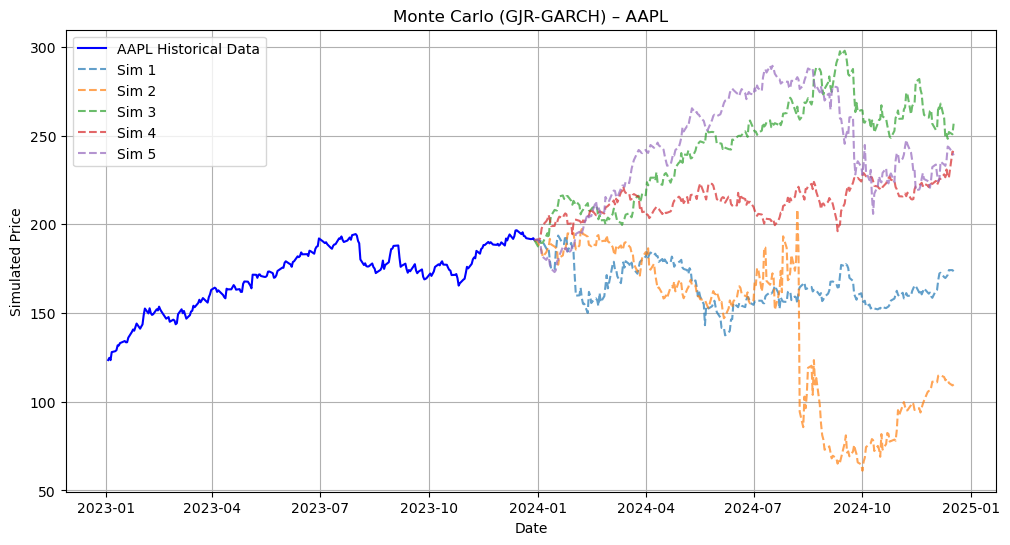

95% Confidence Interval for Final Prices (GJR-GARCH): (281.65, 293.35)


In [30]:
from scipy import stats

def monte_carlo_gjr_garch(GJR_model, last_price, num_simulations=5, num_days=252):
    params = GJR_model.params
    mu = params['mu']
    omega = params['omega']
    alpha = params['alpha[1]']
    beta = params['beta[1]']
    gamma = params['gamma[1]']
    nu = params['nu']

    simulations = []  # List to store all simulated price paths
    for _ in range(num_simulations):
        prices = [last_price]  # Initialize with the last observed price
        h = [GJR_model.conditional_volatility.iloc[-1] ** 2]  # Initial variance (squared volatility)
        for t in range(num_days):
            # Draw random innovation from standardized Student-t distribution
            z = np.random.standard_t(df=nu)
            scaled_z = z * np.sqrt((nu - 2) / nu)
            epsilon = scaled_z * np.sqrt(h[-1])  # Shock based on current volatility
            # Update conditional variance using GJR-GARCH formula
            indicator = 1 if epsilon < 0 else 0  # Leverage effect indicator
            new_h = omega + alpha * epsilon**2 + gamma * epsilon**2 * indicator + beta * h[-1]
            h.append(new_h)
            # Update the price using the log-normal return process
            new_price = prices[-1] * np.exp(mu / 100 + epsilon / 100)  # Returns are scaled (×100)
            prices.append(new_price)
        simulations.append(prices)  # Store the full path
    return simulations


def plot_monte_carlo_garch(data, simulations, ticker, start_date='2023-01-01'):
    # Filter historical data from the given start date
    filtered_data = data[data.index >= start_date]
    plt.figure(figsize=(12, 6))
    # Plot historical closing prices
    plt.plot(filtered_data['Close'], label=f'{ticker} Historical Data', color='blue')
    # Generate business-day time index for the simulation horizon
    time_index = pd.date_range(start=data.index[-1], periods=len(simulations[0]), freq='B')
    # Plot each simulated trajectory
    for i, simulation in enumerate(simulations):
        plt.plot(time_index, simulation, linestyle='--', alpha=0.7, label=f'Sim {i+1}')
    plt.title(f'Monte Carlo (GJR-GARCH) – {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Simulated Price')
    plt.legend()
    plt.grid(True)
    plt.show()


# Last observed closing price
last_price = data['Close'].dropna().iloc[-1]

# Run 5 Monte Carlo simulations and plot
simulations = monte_carlo_gjr_garch(GJR_model, last_price, num_simulations=5, num_days=252)
plot_monte_carlo_garch(data, simulations, 'AAPL', start_date='2023-01-01')

# Run 2000 simulations to estimate distribution of final prices
final_prices = []
for path in monte_carlo_gjr_garch(GJR_model, last_price, num_simulations=2000, num_days=252):
    final_prices.append(path[-1])
final_prices = np.array(final_prices)

# Compute 95% confidence interval for the final simulated prices
mean = np.mean(final_prices)
std_err = np.std(final_prices, ddof=1) / np.sqrt(len(final_prices))
z_crit = stats.norm.ppf((1 + 0.95) / 2)
margin_of_error = z_crit * std_err
ci_lower = mean - margin_of_error
ci_upper = mean + margin_of_error
print(f"95% Confidence Interval for Final Prices (GJR-GARCH): ({ci_lower:.2f}, {ci_upper:.2f})")


### Observations from GJR-GARCH Monte Carlo Simulation

The simulated price trajectories generated using the GJR-GARCH(1,1) model reflect more realistic market dynamics compared to a constant-volatility Brownian motion. Specifically:

- **Volatility clustering** is clearly observed: after sharp downward shocks, volatility tends to remain elevated for some time.
- **Asymmetric responses to shocks**: negative returns generate larger volatility increases due to the leverage effect captured by the GJR term (*γ > 0*).
- **Fatter tails** in the distribution of outcomes: the model's use of a Student's *t*-distribution captures heavy tails and extreme scenarios more effectively.
- **Divergence in paths**: the simulations spread significantly over time, reflecting the model's ability to reflect volatility persistence and uncertainty.
- **Spikes and jumps**: some paths exhibit sudden large deviations, mimicking real-world phenomena such as crashes or rallies.

These features demonstrate how GARCH-type models, especially GJR-GARCH, incorporate key **stylized facts** of financial time series, making them more robust for **risk forecasting** and **scenario analysis** than classical constant-volatility models.


## Conclusion

This project highlights the impact of volatility modeling on Monte Carlo price simulations:

- The **historical GBM model** is simple and intuitive, but underestimates market risks by assuming constant volatility and normal shocks.
- The **GJR-GARCH model** introduces realistic dynamics, capturing time-varying volatility, leverage effects, and heavy tails.

Such models are better suited for risk management, option pricing, and financial forecasting under uncertainty.
